# NMIST DATASET
## Henry Salgado
# June 2025


Based on tutorial: https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Multi-input%20Gradient%20Explainer%20MNIST%20Example.html

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np


In [19]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


Image shape: torch.Size([1, 28, 28])
Label: 2


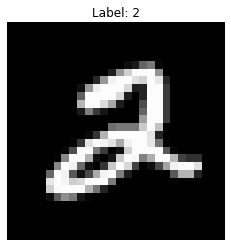

In [20]:
image, label = trainset[5]
print("Image shape:", image.shape) 
print("Label:", label)


plt.imshow(image.squeeze(), cmap="gray")
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()


In [21]:
class FeedforwardCNN(nn.Module):
    def __init__(self):
        super(FeedforwardCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 7 * 7, 64)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x


In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FeedforwardCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [23]:
epochs = 2

for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

       
        optimizer.zero_grad()

      
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(trainloader)}")


Epoch 1, Loss: 0.26476455088466533
Epoch 2, Loss: 0.07436180500281868


In [24]:
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total:.2f}%")


Accuracy on test set: 98.22%


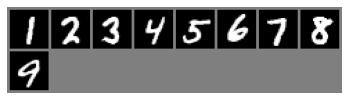

Labels: [1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6]


In [25]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

imshow(torchvision.utils.make_grid(images[:9]))
print("Labels:", labels[:20].tolist())


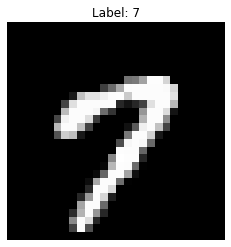

In [26]:
image, label = trainset[15]
image = image.unsqueeze(0).to(device) 


plt.imshow(image.squeeze(), cmap="gray")  
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()


White = high activation

Black = low activation

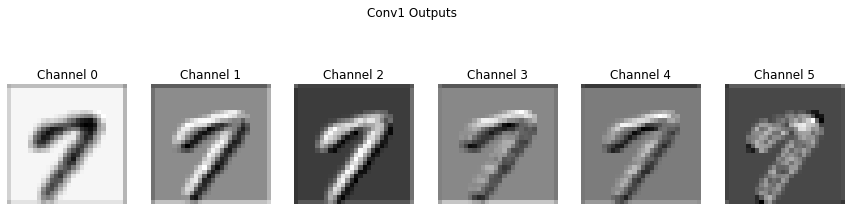

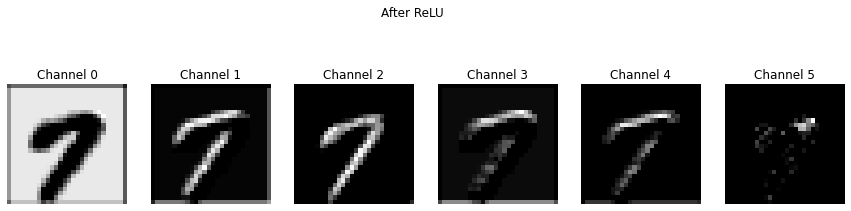

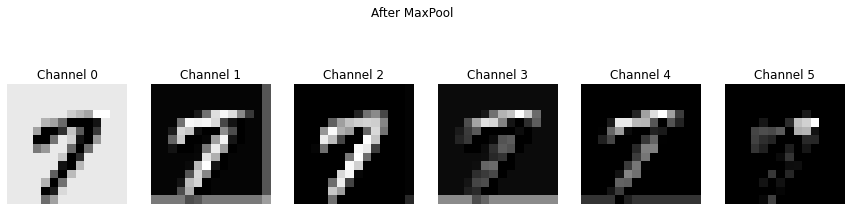

In [27]:


with torch.no_grad():
    act1 = model.conv1(image)       
    act1_relu = model.relu1(act1)   
    act1_pool = model.pool1(act1_relu)


import matplotlib.pyplot as plt

def plot_activations(activation, title="Activations"):
    num_features = activation.shape[1]
    fig, axes = plt.subplots(1, min(6, num_features), figsize=(15, 4))
    for i in range(min(6, num_features)):
        ax = axes[i]
        ax.imshow(activation[0, i].cpu(), cmap='gray')
        ax.axis('off')
        ax.set_title(f'Channel {i}')
    fig.suptitle(title)
    plt.show()


plot_activations(act1, title="Conv1 Outputs")
plot_activations(act1_relu, title="After ReLU")
plot_activations(act1_pool, title="After MaxPool")


In [28]:
import torch.nn.functional as F

class WrappedModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def forward(self, x):
        logits = self.model(x)
        return F.softmax(logits, dim=1) 


In [29]:
import shap
import torch


background = next(iter(trainloader))[0][:100].to(device) 
samples_to_explain = next(iter(testloader))[0][:10].to(device)  


wrapped_model = WrappedModel(model).to(device)
wrapped_model.eval()


WrappedModel(
  (model): FeedforwardCNN(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=784, out_features=64, bias=True)
    (relu3): ReLU()
    (fc2): Linear(in_features=64, out_features=10, bias=True)
  )
)

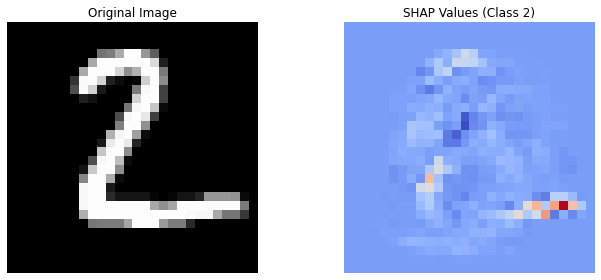

In [30]:
import matplotlib.pyplot as plt


sample_idx = 1
class_idx = 2


img_np = samples_to_explain[sample_idx].detach().cpu().numpy().squeeze()


shap_img = shap_values[class_idx][sample_idx].squeeze()


plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img_np, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(shap_img, cmap='coolwarm')  
plt.title(f"SHAP Values (Class {class_idx})")
plt.axis('off')

plt.tight_layout()
plt.show()


In [45]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.utils import to_categorical

In [46]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

In [47]:
model = Sequential()

model.add(Conv2D(
    8,
    kernel_size=(3, 3),
    activation='relu',
    input_shape=(28, 28, 1)
))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))  


model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


model.fit(x_train, y_train_cat, epochs=4, batch_size=128, validation_split=0.1)

score = model.evaluate(x_test, y_test_cat, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Epoch 1/4
422/422 [==============================] - 4s 9ms/step - loss: 0.4786 - accuracy: 0.8575 - val_loss: 0.1265 - val_accuracy: 0.9648
Epoch 2/4
422/422 [==============================] - 4s 9ms/step - loss: 0.2005 - accuracy: 0.9404 - val_loss: 0.0761 - val_accuracy: 0.9780
Epoch 3/4
422/422 [==============================] - 4s 9ms/step - loss: 0.1556 - accuracy: 0.9529 - val_loss: 0.0678 - val_accuracy: 0.9807
Epoch 4/4
422/422 [==============================] - 4s 10ms/step - loss: 0.1313 - accuracy: 0.9603 - val_loss: 0.0557 - val_accuracy: 0.9850
Test loss: 0.06531637907028198
Test accuracy: 0.9794999957084656


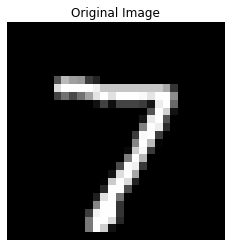

In [48]:
import numpy as np
import matplotlib.pyplot as plt

sample_image = x_test[0].reshape(1, 28, 28, 1)

plt.imshow(sample_image[0, :, :, 0], cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 37ms/step


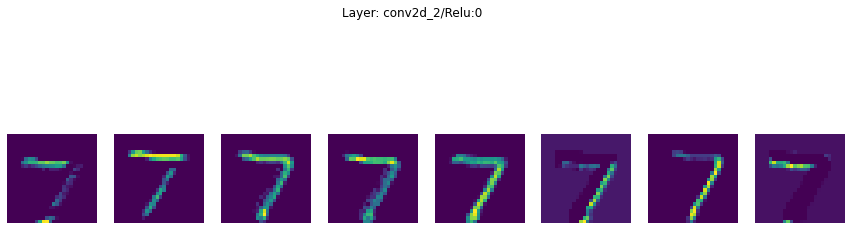

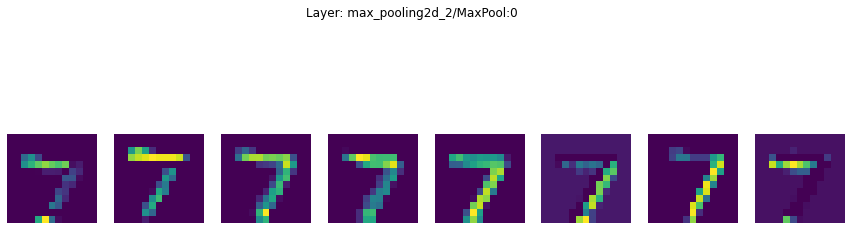

In [49]:
from tensorflow.keras.models import Model


layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name or 'pool' in layer.name]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(sample_image)

import matplotlib.pyplot as plt

def display_activation(activation, title, max_images=8):
    num_filters = min(activation.shape[-1], max_images)
    plt.figure(figsize=(15, 5))
    for i in range(num_filters):
        plt.subplot(1, num_filters, i + 1)
        plt.imshow(activation[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()


for layer_output, layer in zip(activations, activation_model.outputs):
    display_activation(layer_output, title=f"Layer: {layer.name}")



In [50]:
import shap

x_sample = shap.sample(x_train, 100)
explainer = shap.GradientExplainer(model, data=x_sample)
shap_values = explainer.shap_values(x_test[:4])

10


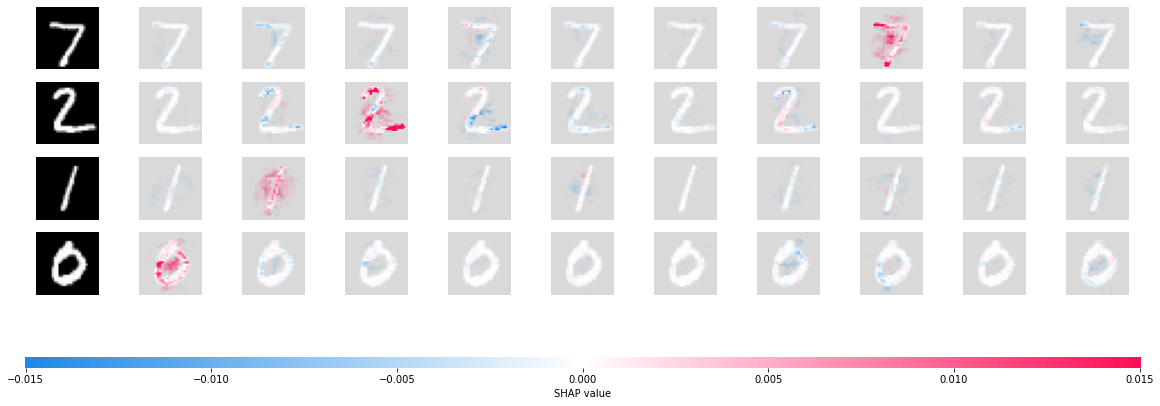

In [51]:
print(len(shap_values))
shap.image_plot(shap_values, x_test[:4])

## Let's grab examples that have 7s

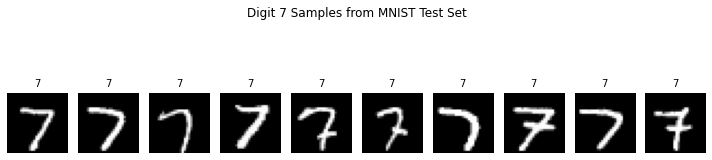

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


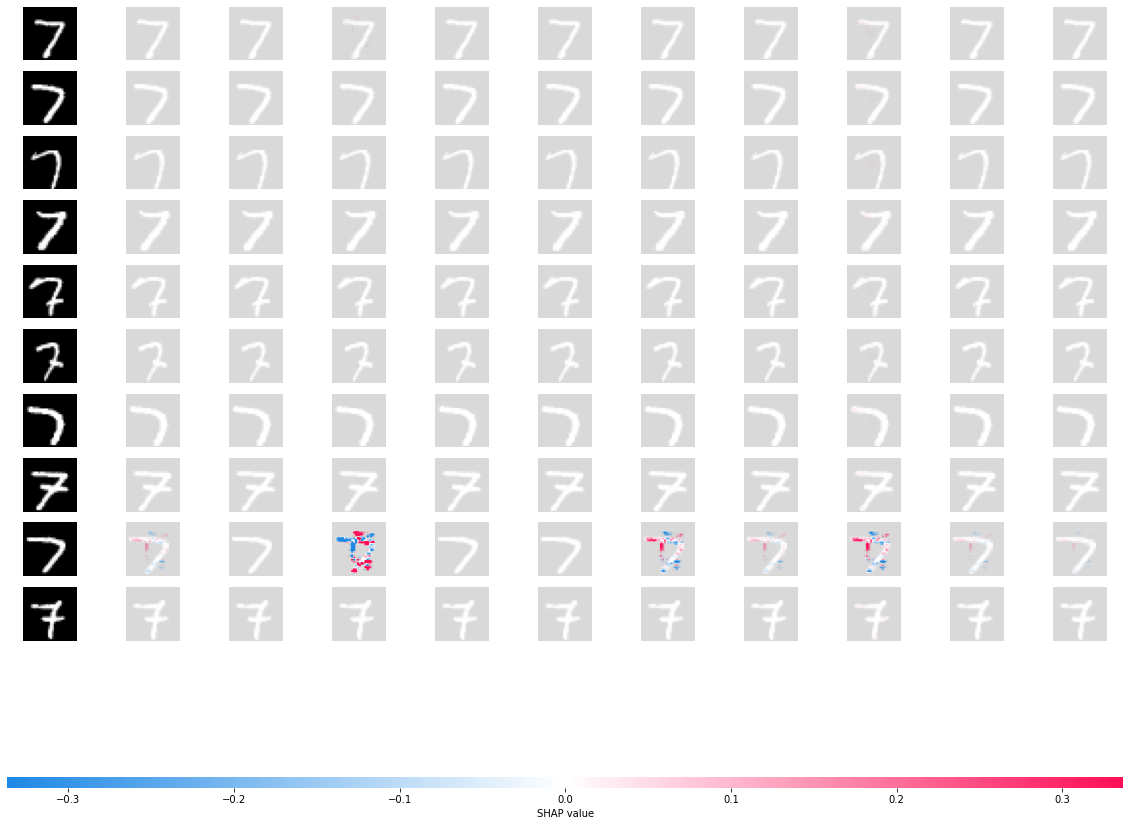

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import shap

# Get 10 digit 7 images
digit_7_indices = np.where(y_test == 7)[0][:10]
digit_7_images_np = x_test[digit_7_indices]  # Shape: (10, 28, 28, 1)

# Plot them
plt.figure(figsize=(10, 3))
for i in range(len(digit_7_images_np)):
    plt.subplot(1, 10, i + 1)
    plt.imshow(digit_7_images_np[i].squeeze(), cmap='gray')
    plt.title("7", fontsize=10)
    plt.axis('off')
plt.suptitle("Digit 7 Samples from MNIST Test Set")
plt.tight_layout()
plt.show()

# SHAP part
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]  # Shape: (100, 28, 28, 1)

# Ensure model is a Keras model
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(digit_7_images_np)

# Plot SHAP values
shap.image_plot(shap_values, digit_7_images_np)


1/1 [==============================] - 0s 52ms/step


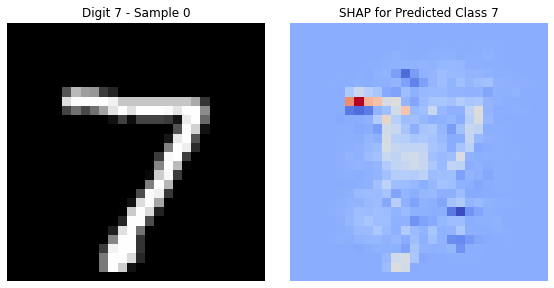

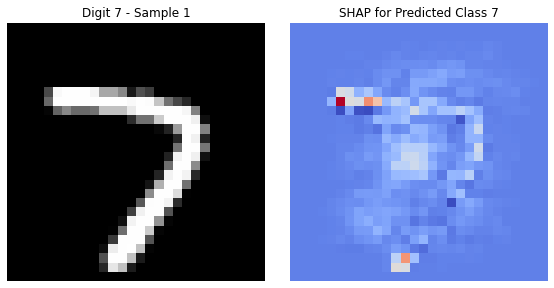

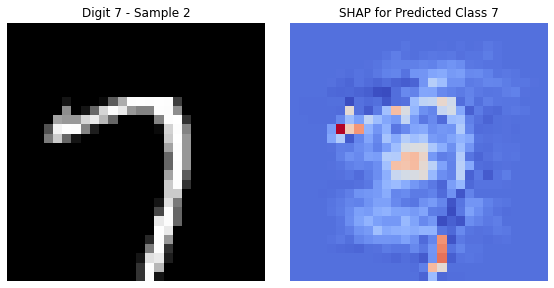

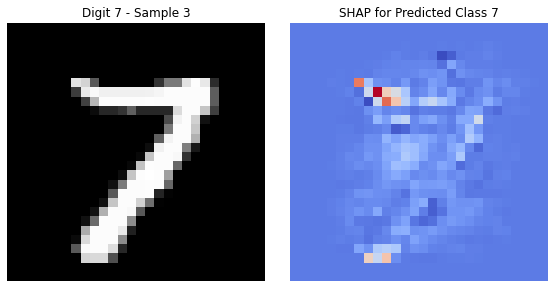

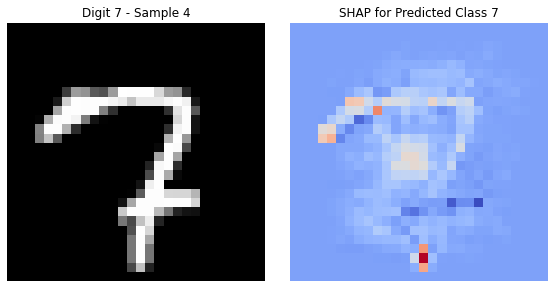

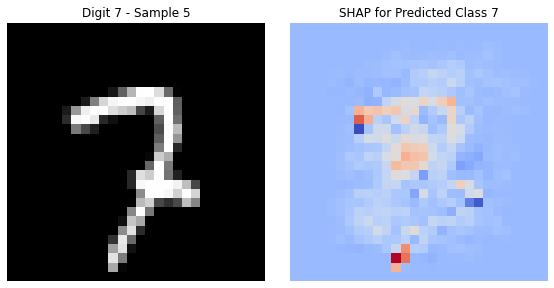

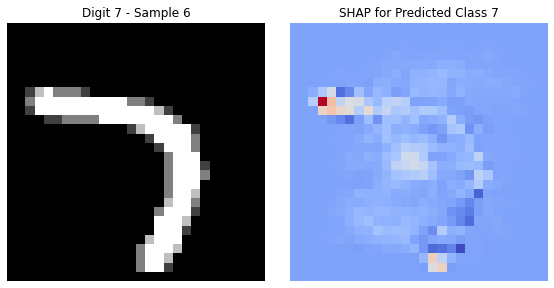

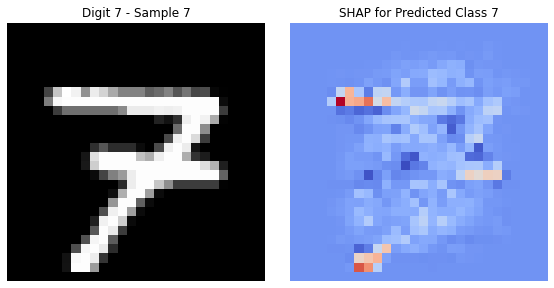

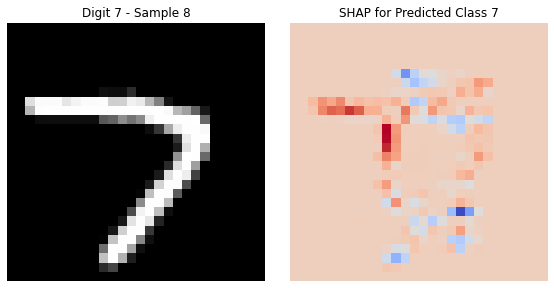

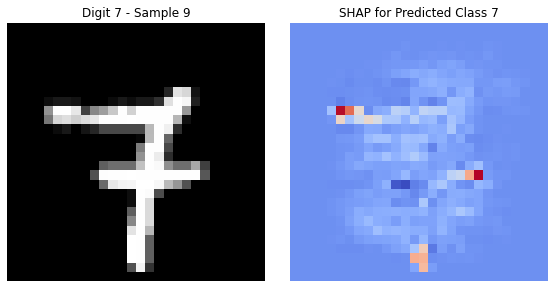

In [54]:
import matplotlib.pyplot as plt


preds = model.predict(digit_7_images_np).argmax(axis=1)


for i in range(len(digit_7_images_np)):
    class_idx = preds[i]
    shap_img = shap_values[class_idx][i].squeeze()
    orig_img = digit_7_images_np[i].squeeze()

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(orig_img, cmap='gray')
    plt.title(f"Digit 7 - Sample {i}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(shap_img, cmap='coolwarm')
    plt.title(f"SHAP for Predicted Class {class_idx}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


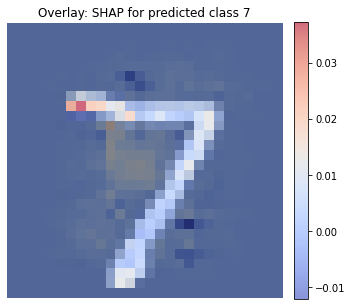

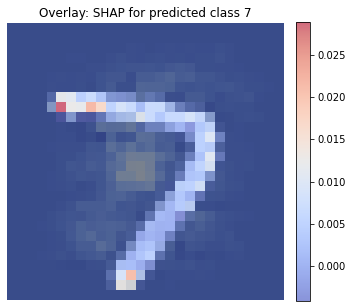

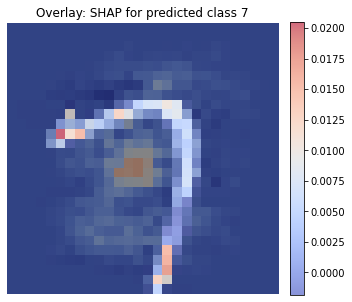

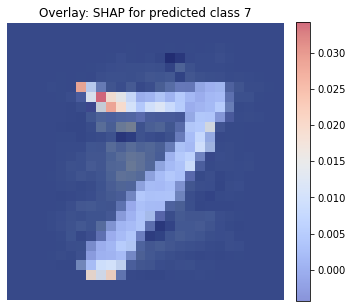

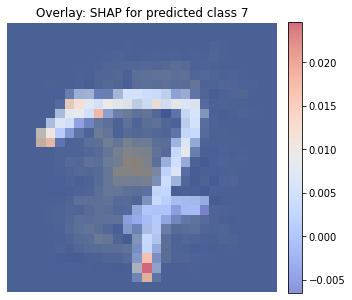

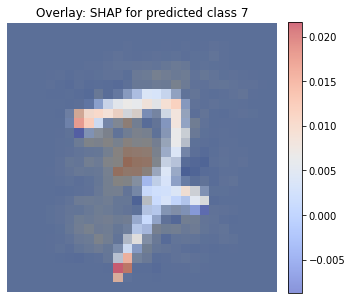

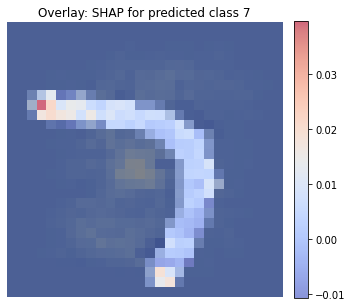

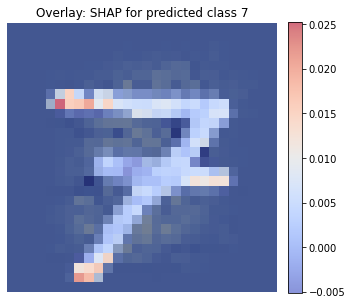

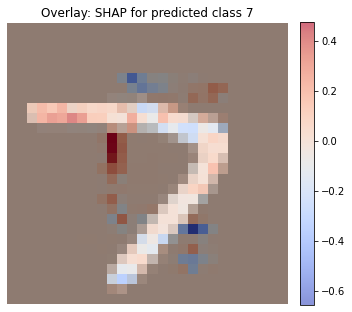

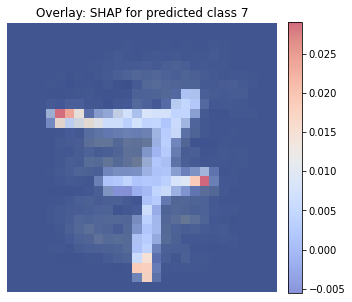

In [55]:
import matplotlib.pyplot as plt
import numpy as np


for i in range(len(digit_7_images_np)):
    original_img = digit_7_images_np[i].squeeze()
    class_idx = preds[i]
    shap_img = shap_values[class_idx][i].squeeze()

    plt.figure(figsize=(5, 5))
    plt.imshow(original_img, cmap='gray', alpha=1.0)  # base image
    plt.imshow(shap_img, cmap='coolwarm', alpha=0.6)  # SHAP heatmap overlay
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.title(f"Overlay: SHAP for predicted class {class_idx}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


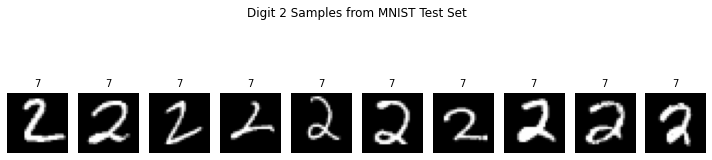

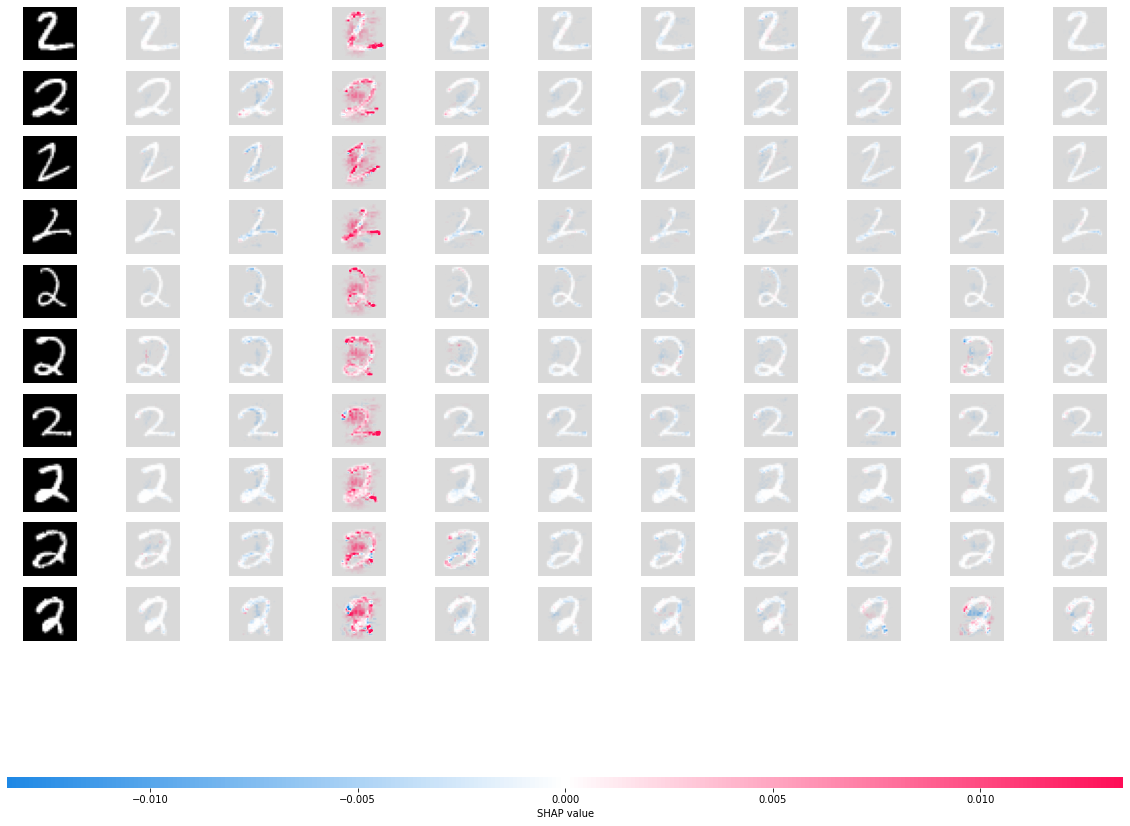

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import shap


digit_2_indices = np.where(y_test == 2)[0][:10]
digit_2_images_np = x_test[digit_2_indices]  


plt.figure(figsize=(10, 3))
for i in range(len(digit_2_images_np)):
    plt.subplot(1, 10, i + 1)
    plt.imshow(digit_2_images_np[i].squeeze(), cmap='gray')
    plt.title("7", fontsize=10)
    plt.axis('off')
plt.suptitle("Digit 2 Samples from MNIST Test Set")
plt.tight_layout()
plt.show()



# Ensure model is a Keras model
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(digit_2_images_np)

# Plot SHAP values
shap.image_plot(shap_values, digit_2_images_np)


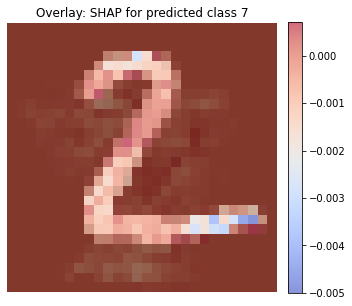

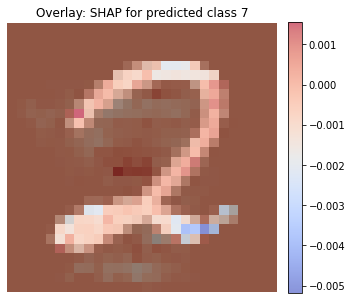

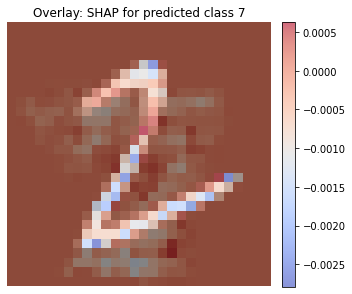

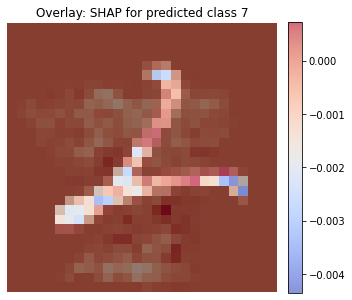

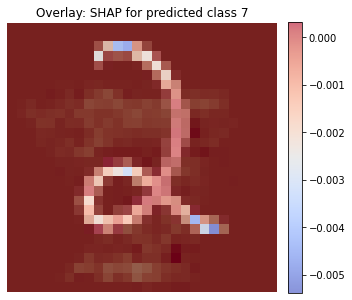

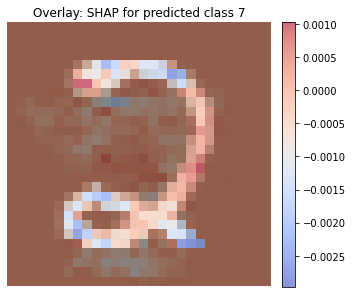

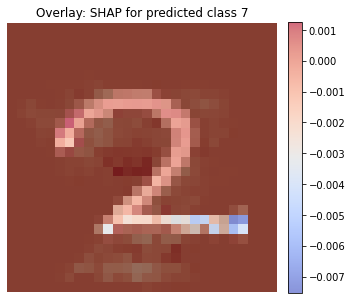

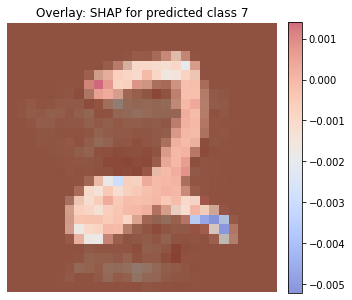

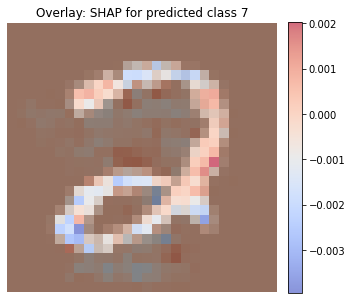

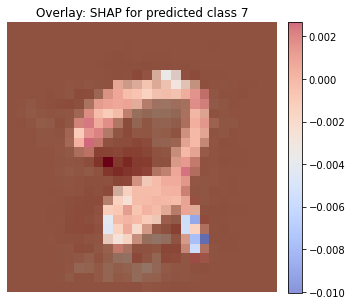

In [60]:
import matplotlib.pyplot as plt
import numpy as np


for i in range(len(digit_2_images_np)):
    original_img = digit_2_images_np[i].squeeze()
    class_idx = preds[i]
    shap_img = shap_values[class_idx][i].squeeze()

    plt.figure(figsize=(5, 5))
    plt.imshow(original_img, cmap='gray', alpha=1.0)  
    plt.imshow(shap_img, cmap='coolwarm', alpha=0.6)  
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.title(f"Overlay: SHAP for predicted class {class_idx}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


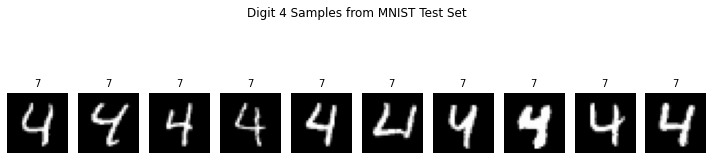

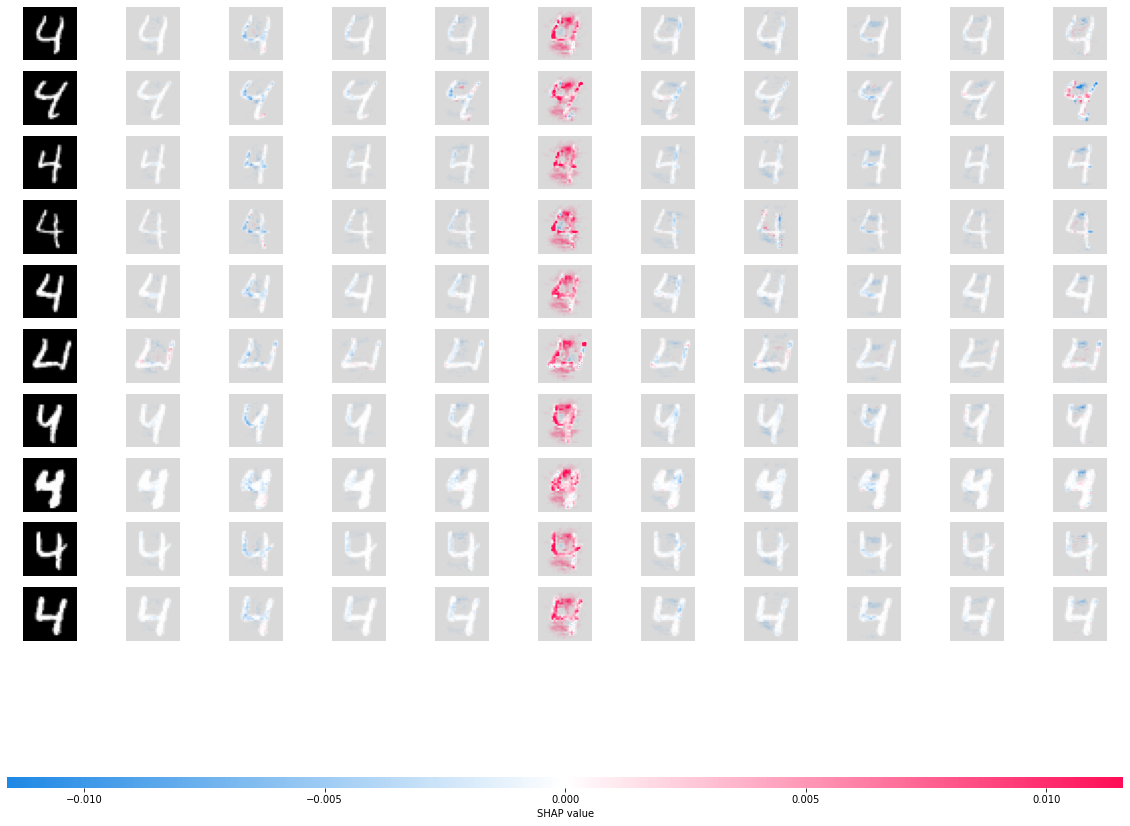

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import shap


digit_4_indices = np.where(y_test == 4)[0][:10]
digit_4_images_np = x_test[digit_4_indices]  


plt.figure(figsize=(10, 3))
for i in range(len(digit_4_images_np)):
    plt.subplot(1, 10, i + 1)
    plt.imshow(digit_4_images_np[i].squeeze(), cmap='gray')
    plt.title("7", fontsize=10)
    plt.axis('off')
plt.suptitle("Digit 4 Samples from MNIST Test Set")
plt.tight_layout()
plt.show()



explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(digit_4_images_np)


shap.image_plot(shap_values, digit_4_images_np)


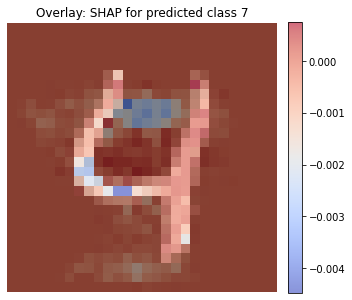

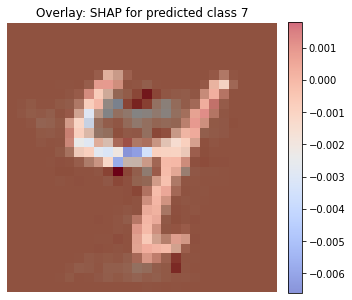

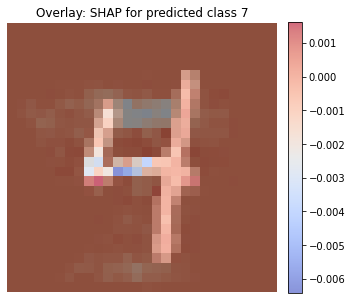

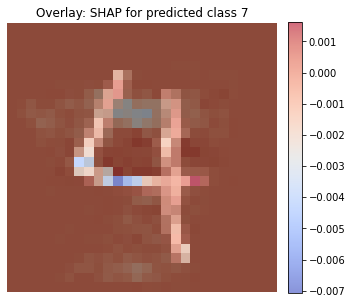

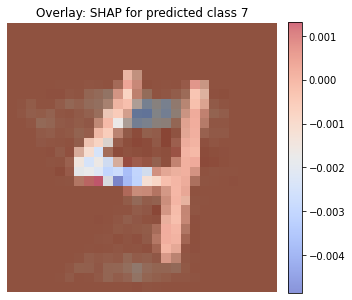

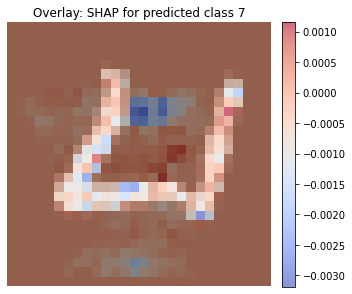

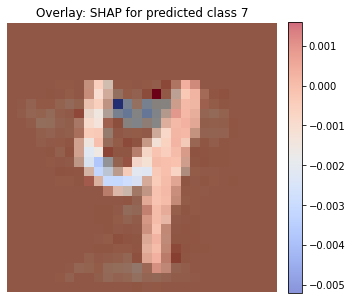

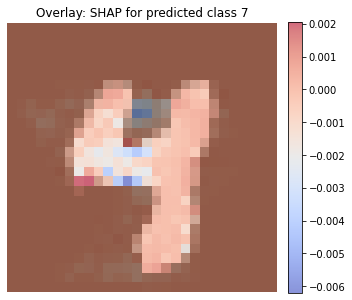

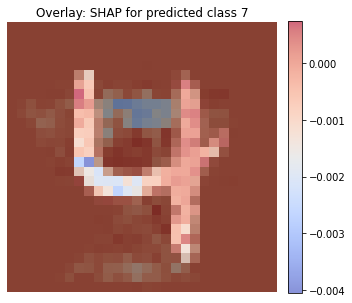

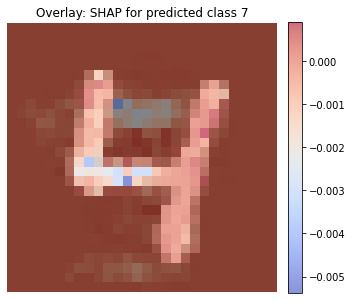

In [62]:
import matplotlib.pyplot as plt
import numpy as np


for i in range(len(digit_4_images_np)):
    original_img = digit_4_images_np[i].squeeze()
    class_idx = preds[i]
    shap_img = shap_values[class_idx][i].squeeze()

    plt.figure(figsize=(5, 5))
    plt.imshow(original_img, cmap='gray', alpha=1.0)  
    plt.imshow(shap_img, cmap='coolwarm', alpha=0.6)  
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.title(f"Overlay: SHAP for predicted class {class_idx}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
